# Rogun HPP - Surface DXF to Nodes in CSV

--- GEOLOGICAL FAULTS (SURFACES) ---

This procedure prepares geological surface data from a CAD DXF and is intended to provide geologicl input to the Hydropower Waterways Decision Support System (Waterways DSS), working together with the 'Alignments DXF to Nodes in CSV' and the 'Setup Basemaps' modules:
- geological layers and faults for feasibilty and siting analysis
- geological layers and faults for visualizing project data.

Various means of using geological surface data for hydropower and geotechnical analysis, which includes data analysis and visualization, have been reviewed:
1. export geometry from CAD (often Civil3d) using a suitable geospatial format and use python procedures for analysis: DXF export is a time-proven and robust solution 
2. perform analysis inside of CAD (probably Civil3d), most probably as plug-in developed using C# and .NET with Civil3d API considered to have a steep learning curve: not a realistic scenario in most engineering consultancy offices
3. perform analysis from CAD ((probably Civil3d) using bindings to an external software development environment (python probably): solution does not yet exist. 

The only practical choice at this time is 1.

Sketchup is currently used to prepare geological surfaces for export in DXF. The surfaces are typically imported from other 3d CAD software and then checked, cleaned up (e.g. simplification, removing overhangs) and made into components using Sketchup. Geological surfaces is used here to refer to contact surfaces between geological layers (typically lithologies) and to fault surfaces.

See Engieering Procedure:  
"Use Sketchup and QGIS to prepare surface nodes as CSV input data"

This procedure adresses in particular mesh data exported as DXF from Sketchup. The exported mesh data is generally LINE (both from Sketchup surfaces and from extensions that I have tried such as Fredo6 Curviloft).

In [1]:
# ToDo

#  'layer' -> 'surface' or 'contact surface' (sometimes - needs review)
#  surface names to be e.g. as 'layer_1' to improve data handling? -> with lithology e.g. 'sandstone_K1ob2'
#  check bottom elevation of surface != 0 (=0 implies artifacts in export)
#  check nr of edge/vertice entities in Sketchup vs grass lines/points


#  all data (e.g. file names) as variables
#  markdown titles
#  comments with explanations of code / grass methods
#  this example use grass script, do again with pygrass defining class & methods? 
#  this work to go into API later


## grass setup for project

In [2]:
# set up Python for GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image

# set up GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
os.environ['GRASS_FONT'] = 'sans'
os.environ['GRASS_OVERWRITE'] = '1'  #overwrite existing maps
sys.path.append(os.path.join(gisbase, "etc", "python"))

# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

# import GRASS GIS
import grass.script as gs
import grass.script.setup as gsetup
from grass.script import core as grass

# for pygrass
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

from subprocess import PIPE

# further setup for GRASS GIS 
gs.set_raise_on_error(True)
#gs.set_capture_stderr(True)  #might be Python 2 vs 3 issue (unsure if Python 3 required for this Notebook)

# additional imports
import numpy as np

In [3]:
# https://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library
# GRASS Python Scripting Library
# How to retrieve error messages from read_command():

def read2_command(*args, **kwargs):                                                 #rename to e.g. read_grass
   kwargs['stdout'] = grass.PIPE
   kwargs['stderr'] = grass.PIPE
   ps = grass.start_command(*args, **kwargs)
   return ps.communicate()

In [4]:
# create a mapset (mapset does not already exist)
# should only do once (but will report error and exit if already exists)

# dir /home/kaelin_joseph/projects/RogunHEP/grassdata  should already exist
!grass -c EPSG:3857 /home/kaelin_joseph/projects/RogunHPP/grassdata/RogunHPP -e
# should use grass scipt                                                                            ToDo JK !!

# define all parameters separately                                                                  ToDo JK !!
#EPSG:3857  #WGS84 Pseudo Mercator

Cleaning up temporary files...
Creating new GRASS GIS location/mapset...
ERROR: Failed to create new location. The location <RogunHPP> already exists.
Exiting...


In [5]:
# open mapset
rcfile = gsetup.init(gisbase, 
         "/home/kaelin_joseph/projects/RogunHPP/grassdata",
         "RogunHPP/", "PERMANENT")

In [6]:
# check grass env
print grass.gisenv()

{'MAPSET': 'PERMANENT', 'GISDBASE': '/home/kaelin_joseph/projects/RogunHPP/grassdata', 'LOCATION_NAME': 'RogunHPP/'}


In [7]:
# check projection info
read2_command('g.proj', flags = 'jf')

('+proj=merc +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +no_defs +a=6378137 +rf=298.257223563 +towgs84=0.000,0.000,0.000 +to_meter=1\n',
 '')

In [8]:
#check mapsets
grass.mapsets()

['PERMANENT']

In [9]:
# set grass region for project
n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog
g.region(n=n,s=s,e=e,w=w, t=3000, b=100, res=5)

Module('g.region')

In [10]:
# check grass region
print(g.region(flags='p3',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      24797
south:      20796
west:       25597
east:       28600
top:        3000.00000000
bottom:     100.00000000
nsres:      5.00125
nsres3:     1.00401506
ewres:      4.99667221
ewres3:     1
tbres:      1.04241552839684
rows:       800
rows3:      3985
cols:       601
cols3:      3003
depths:     2782
cells:      480800
cells3:     33292068810



In [11]:
# remove any existing raster masks (including masks from other procedures using grass data)
#  make this part of basemap class initiation
!r.mask -r

ERROR: No existing MASK to remove


In [12]:
# reference for grass colors
# https://grass.osgeo.org/grass64/manuals/r.colors.html
# https://grass.osgeo.org/grass74/manuals/v.colors.html

# standard GRASS color names: aqua, black, blue, brown, cyan, gray, green, grey, 
#                             indigo, magenta, orange, purple, red, violet, white, yellow

## input data for project

In [13]:
# define geological surfaces to be processed
# 'layers' refers to contact surfaces between geological layers 
# 'layers' is term used in source data imported into Sketchup

# ToDo: improve naming of layer data
#   'contact' or 'surface' would be better terms than 'layer'
#   should then contact name be composed of the two adjoing lithologies?
#   where should the rock type for each lithology be defined in the inout data?
#     - should the rock type be part of the contact name (.dxf data name) and then parsed??

fault_data = ['3']
#lithologies = ['siltstone_K1ob1', 'sandstone_K1ob2', 'siltstone_K1kr']

faults, faults_vect = [], []
faults_points, faults_points_csv = [], []
faults_rast, faults_rast_ = [], []

# define required data files for project
for fault in fault_data:
    # dxf input data files
    faults.append('/home/kaelin_joseph/projects/RogunHPP/data/in/fault_'+str(fault)+'.dxf')
    # grass vector data
    faults_vect.append('fault_'+str(fault))
    faults_points.append('fault_points_'+str(fault))
    # csv output data files
    faults_points_csv.append('/home/kaelin_joseph/projects/RogunHPP/data/out/fault_'+str(fault)+'.csv')
    # grass raster data files
    faults_rast.append('fault_rast_'+str(fault))
    faults_rast_.append('fault_rast__'+str(fault))  #is use of __ really a good idea her??       #ToDo JK

In [14]:
#faults
faults_vect

['fault_3']

## import DXF data to grass vector (lines)

In [15]:
# read dxf data for geological layer contact faults

# 'faults' is a list containing geological faults
# 'faults_vect' is a list containing names of grass vector data
for fault, output in zip(faults, faults_vect):
    print(fault)
    out = read2_command("v.in.dxf", input=fault, output=output, flags='e')
    print(out[1].decode())    
    
# pattern for printing grass output nicely
#   decode must be applied to each member of tuple
#   [0] -> stdout
#   [1] -> stderr
#   above are according to doc, however it seems that [1] is where all output is

/home/kaelin_joseph/projects/RogunHPP/data/in/fault_3.dxf
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11  22  33  44  55  66  77  88  99 100
Following DXF layers found:
Layer 1: 0
Building topology for vector map <fault_3@PERMANENT>...
Registering primitives...
98 primitives registered
222 vertices registered
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  50  52  54  56  58  60  62  64

In [16]:
# set grass region to area of surface of interest
# conisder choosing region to minimize edge artifacts (e.g. ill-formed top edge) of a plotly mesh surface

# # set grass region from vector data bounds
# #   set region using 'surfaces_vect[0]'
# read2_command('g.region', vector=surfaces_vect[0])

#n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog

# determine bounds by inspection of plot result
#n,s,e,w = 23500, 20796, 28600, 27400
#n,s,e,w = 23500, 22743, 27800, 27400
n,s,e,w = 23500, 22743, 27900, 27400  #extend to include all boreholes from DG's
g.region(n=n,s=s,e=e,w=w, t=1500, b=150, res=10)     #res=5

Module('g.region')

In [17]:
# check grass region
print(g.region(flags='p3',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      23500
south:      22743
west:       27400
east:       27900
top:        1500.00000000
bottom:     150.00000000
nsres:      9.96052632
nsres3:     1.00397878
ewres:      10
ewres3:     1
tbres:      1.04247104247104
rows:       76
rows3:      754
cols:       50
cols3:      500
depths:     1295
cells:      3800
cells3:     488215000



In [18]:
def report_vect(surface_vect):
# report of vector data imported from dxf
#  comment out individual reporting as desired

    # report imported DXF layers
    print(surface_vect)
    print(read2_command("v.info", map=surface_vect, layer='-1', verbose=True)[0].decode()) 

#     # report entities in imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.db.select", map=surface_vect)[0].splitlines()
#     for line in range(0,4):
#         print(out[line])

#     # report categories in imported DXF layers
#     print('\n')
#     print(read2_command("v.category", input=surface_vect, layer='-1', option='report', verbose=True)[0].decode()) 

#     # report coordinatesin imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.report", map=surface_vect, layer='-1', option='coor', verbose=True)[0].splitlines()
#     for line in range(0,1):
#         print(out[line])

#     # report on attributes stored in grass sqlite database
#     print('\n')
#     print(read2_command("v.db.connect", map=surface_vect, flags='c', verbose=True)[0].decode()) 


for fault in faults_vect:
    report_vect(fault)

fault_3
 +----------------------------------------------------------------------------+
 | Name:            fault_3                                                   |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           fault_3                                                   |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native      

rm: cannot remove 'map.png': No such file or directory


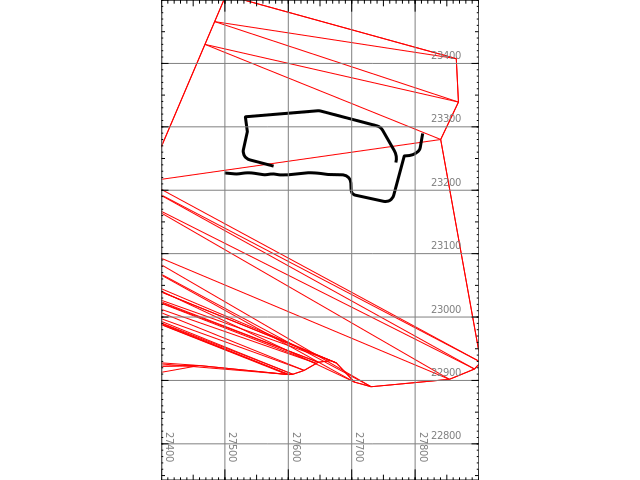

In [19]:
# view and check imported topography
#   view selected faults n 'faults_vect[n]'
!rm map.png                                                                                #ToDo JK: pythonize
read2_command("d.vect", map=faults_vect[0], color='red')
#read2_command("d.vect", map=faults_vect[1], color='purple')
#read2_command("d.vect", map=faults_vect[2], color='green')

# display Drainage Gallery DG3 alignment
read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=3)
read2_command('d.vect', map='alignment_dg2_cleaned', color='black', width=3)

read2_command("d.grid", size=100, fontsize=10)[0]

Image(filename="map.png")

## extract points (unordered) from imported DXF vector data

In [20]:
# extract points from vector data from dxf to grass points vector data
# all points in vector data ouput, points are not restricted by map region

# 'faults_vect' is a list containing names of grass vector data
# 'faults_points' is a list containing grass points vector data
for fault, fault_points in zip(faults_vect, faults_points):
    out = read2_command("v.to.points", input=fault, output=fault_points)     
    print(out[1].decode())

   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Building topology for vector map <fault_points_3@PERMANENT>...
Registering primitives...
420 primitives registered
420 vertices registered
Building areas...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  54%  56%  58%  60%  62%  64%  66%  68%  70%  72%  74%  76%  78%  80%  82%  84%  86%  88%  90%  92%  94%  96%  98% 1

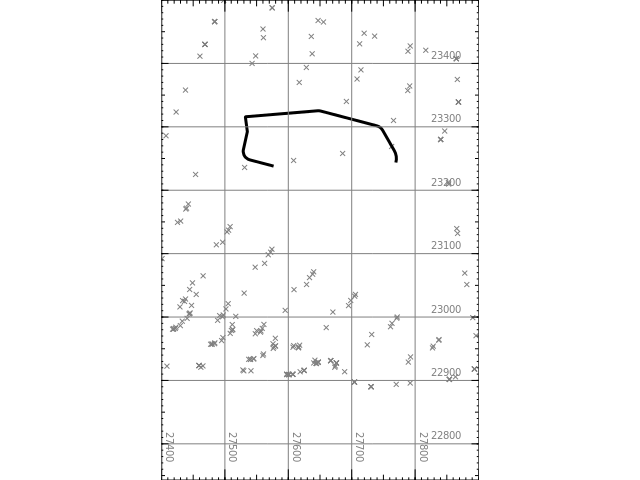

In [21]:
# view and check points topography
#   view selected faul n 'faults_vect[n]'
!rm map.png
read2_command("d.vect", map=faults_points[0], color='grey')
#read2_command("d.vect", map=faults_points[1], color='purple')
#read2_command("d.vect", map=faults_points[2], color='green')

# display Drainage Gallery DG3 alignment
read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=3)

read2_command("d.grid", size=100, fontsize=10)[0]

Image(filename="map.png")

## write points to CSV data file

In [22]:
# extract points from grass points vector data to csv data file
# only points in currently defined map 3d region are output
#   check that top and bottom elevations are set appropriately

# 'faults_points' is a list containing grass points vector data    
# 'faults_points_csv' is a list containing csv data file names for fault nodes
for fault_points, fault_points_csv in zip(faults_points, faults_points_csv):
    out = read2_command("v.out.ascii", input=fault_points, type='point', separator=',',
                        layer=-1, output=fault_points_csv, flags='r') 
    print(out[1].decode())

#!v.out.ascii  --help

In [23]:
faults_points_csv

['/home/kaelin_joseph/projects/RogunHPP/data/out/fault_3.csv']

In [24]:
# examine output points in csv files
!wc '/home/kaelin_joseph/projects/RogunHPP/data/out/fault_3.csv'
!wc '/home/kaelin_joseph/projects/RogunHPP/data/out/fault_2.csv'
!wc '/home/kaelin_joseph/projects/RogunHPP/data/out/fault_1.csv'

  235   235 10085 /home/kaelin_joseph/projects/RogunHPP/data/out/fault_3.csv
wc: /home/kaelin_joseph/projects/RogunHPP/data/out/fault_2.csv: No such file or directory
wc: /home/kaelin_joseph/projects/RogunHPP/data/out/fault_1.csv: No such file or directory


In [25]:
#!head -5 '/home/kaelin_joseph/projects/RogunHPP/data/out/fault_3.csv'

from __future__ import print_function
file = faults_points_csv[0]
with open(file, 'r') as f:
#   for line in f:
    for n in range(500):
        line = f.readline()
        print(line, end='')

27408.59863281,22922.5078125,1008.07467651
27459.19140625,22923.5390625,1026.66699219
27459.19140625,22923.5390625,1026.66699219
27459.19140625,22923.5390625,1026.66699219
27459.19140625,22923.5390625,1026.66699219
27528.37792969,22916.53222656,1083.15875244
27597.56445312,22909.52539062,1139.6505127
27597.56445312,22909.52539062,1139.6505127
27529.8226475,22915.18130226,1075.69127156
27462.08084187,22920.8372139,1011.73203043
27597.56445312,22909.52539062,1139.6505127
27537.54541115,22933.3077465,1071.27209628
27477.52636918,22957.09010238,1002.89367986
27417.5073272,22980.87245825,934.51526344
27597.56445312,22909.52539062,1139.6505127
27600.98632812,22909.23046875,1140.61425781
27600.98632812,22909.23046875,1140.61425781
27540.28291115,22933.071809,1072.04309237
27479.57949418,22956.91314925,1003.47192693
27418.8760772,22980.7544895,934.90076149
27600.98632812,22909.23046875,1140.61425781
27540.43665229,22933.4326617,1071.95511751
27479.88697645,22957.63485465,1003.29597722
27419.33

## rasterize vector surfaces

In [26]:
# define functions used for rastering

def read_grass(*args, **kwargs):                                                                      
    """execute a grass function with error output """                                                       
    kwargs['stdout'] = grass.PIPE                                                                           
    kwargs['stderr'] = grass.PIPE                                                                           
    ps = grass.start_command(*args, **kwargs)                                                               
    # returns a tuple (stderr,stdout)                                                                       
    return ps.communicate()    

def rasterize_vect_using_points(fault_points, fault_rast, 
                                npoints=12, power=2, dbg=1):                                          
    """convert vector topograpy using extracted points to raster dem"""                                     
    
    # convert vect to raster DEM using v.surf.idw (inverse distance weighting interpolation) 
    out = read_grass("v.surf.idw", input=fault_points, 
                     layer='-1', output=fault_rast, npoints=npoints, power=power)             
    print(out[dbg].decode())                                                                                
    print('rasterize_vect_using_points completed')     

In [27]:
#faults_points
faults_rast

['fault_rast_3']

In [28]:
# rasterize faults from vector data containing extracted points from dxf data

# 'faults_points' is a list containing grass points vector data    
# 'faults_rast' is a list containing grass faults raster data
for fault_points, fault_rast in zip(faults_points, faults_rast):
    rasterize_vect_using_points(fault_points, fault_rast) 

Input vector map <fault_points_3@PERMANENT> is 3D - using z-coordinates to
interpolate
241 points loaded
Interpolating raster map <fault_rast_3> (76 rows, 50 columns)...
   0%   2%   5%   7%   9%  11%  13%  15%  17%  19%  21%  23%  25%  27%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  55%  57%  59%  61%  63%  65%  67%  69%  71%  73%  75%  77%  80%  82%  84%  86%  88%  90%  92%  94%  96%  98% 100%
v.surf.idw complete.

rasterize_vect_using_points completed


In [29]:
# resample raster fault, applying mask to raster fault using corresponding vector data 
# 'faults_points' is a list containing grass points vector data    
# 'faults_rast' is a list containing grass faults raster data
# 'faults_rast_' is a list containing grass faults resampled raster data

for fault_rast, fault_rast_, fault_points in zip(faults_rast, faults_rast_, faults_points):
    
    # define raster mask based on vector data bounds
    # creates a convex hull around points (since no area data in vector data)
    read_grass("r.mask", vector = fault_points) 
    
    out = read_grass("r.resamp.rst", input = fault_rast,                                     
                     elevation = fault_rast_, ew_res=10, ns_res=10) 

    print(out[1].decode())  
    
# remove raster mask used for fault raster resampling
!r.mask -r

Processing all selected output files will require
14.84 KB of disk space for temp files.
Temporarily changing the region to desired resolution ...
Bitmap mask created
Changing back to the original region ...
Percent complete:
   0   2   4   6   8  11  13  16  18  20  22  24  27  29  32  34  37  39  41  43  45  48  50  53  55  58  60  62  64  66  69  71  74  76  79  81  83  85  87  90  92  95  97 100
dnorm in ressegm after grid before out2= 123.851567 
dnorm in mainc after grid before out1= 123.851567
dnorm in mainc after grid before out2= 123.851567
r.resamp.rst complete.

Raster MASK removed


In [30]:
# report grass faults raster data
print(read_grass("r.info", map='fault_rast_3')[0].decode())
#print(read_grass("r.report", map='fault_rast_5a', units='h,p', nsteps=10)[0].decode()) 

# report grass faults resampledraster data
print(read_grass("r.univar", map='fault_rast__3')[0].decode()) 

 +----------------------------------------------------------------------------+
 | Map:      fault_rast_3                   Date: Tue Oct 30 14:33:57 2018    |
 | Mapset:   PERMANENT                      Login of Creator: kaelin_joseph   |
 | Location: RogunHPP/                                                        |
 | DataBase: /home/kaelin_joseph/projects/RogunHPP/grassdata                  |
 | Title:     ( fault_rast_3 )                                                |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    DCELL                                                      |
 |   Rows:         76                                                         |
 |   Columns:      50                   

         Your current region setting may be too large. Cells displayed on
         your graphics window may be too small for cell category number to
         be visible.
WARNING: MONITOR variable defined, GRASS_RENDER_IMMEDIATE ignored
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600


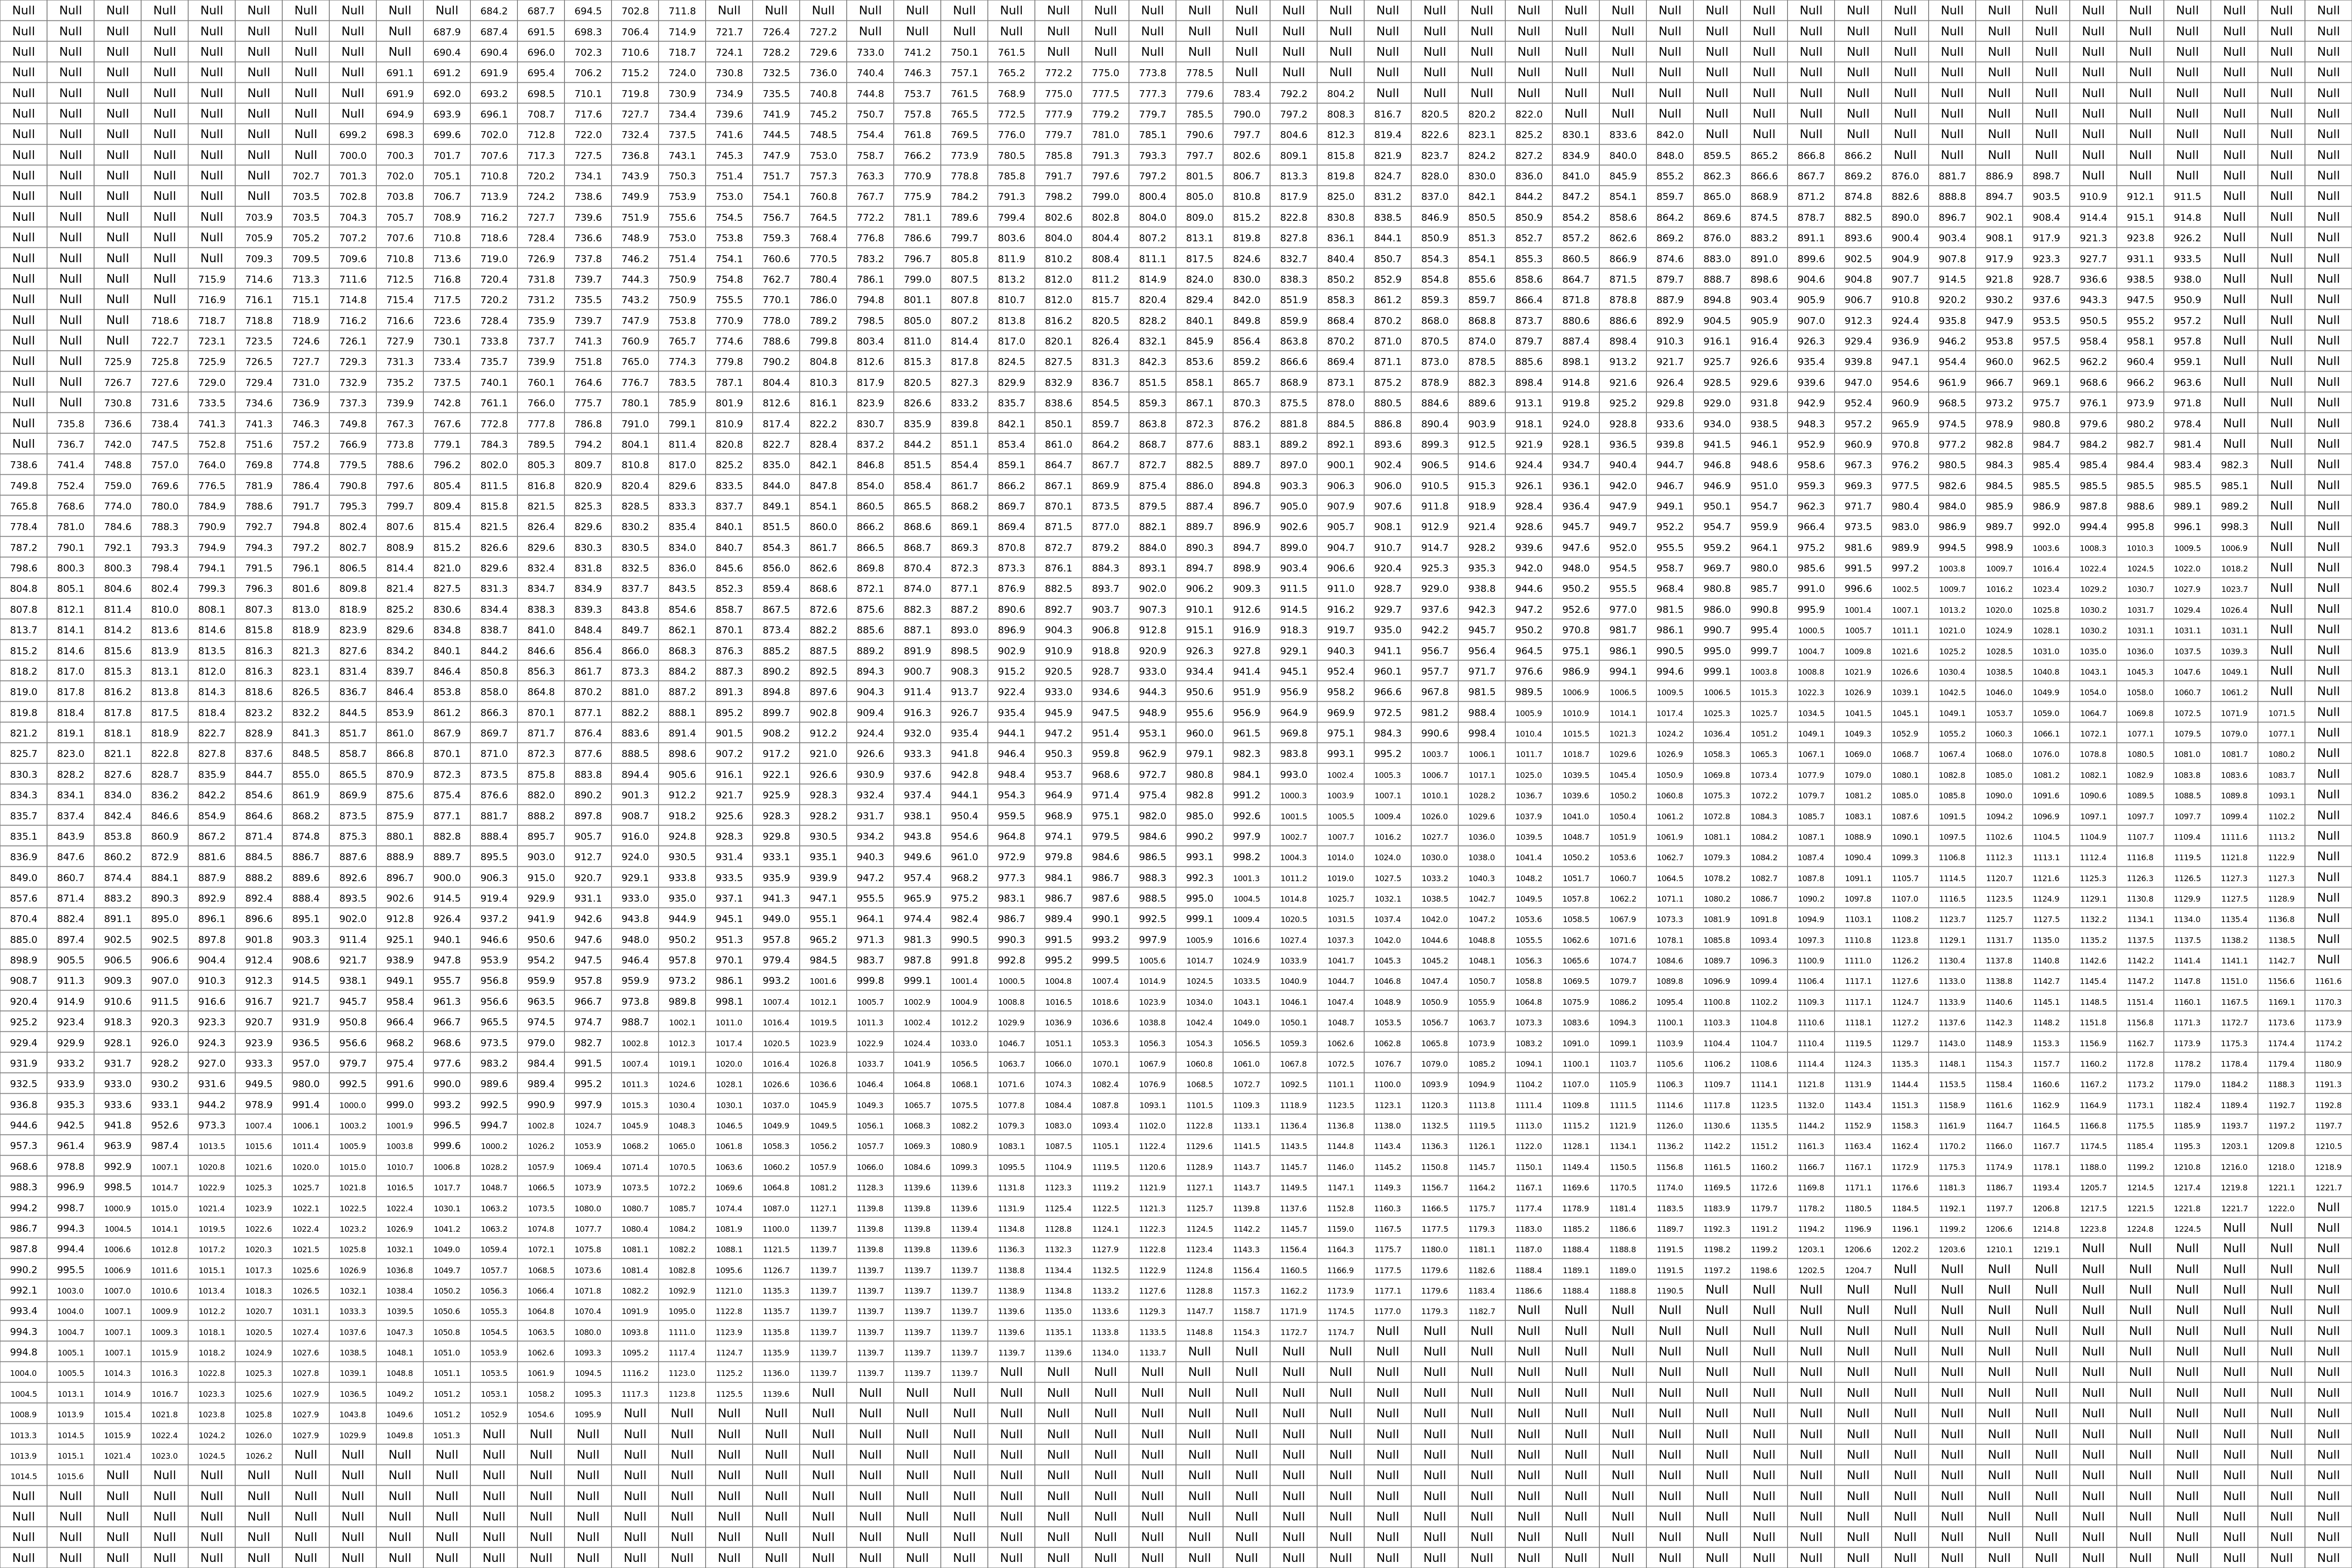

In [31]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)

# for troubleshooting
#https://grass.osgeo.org/grass77/manuals/d.rast.num.html
#!d.rast.num fault_rast_3 --verbose -a  #values look ok, except raster area outside of fault is not null
!d.rast.num fault_rast__3 --verbose -a  #values look ok and raster area outside of fault is null
#!d.rast.leg faults_rast --verbose

Image(filename="map.png")

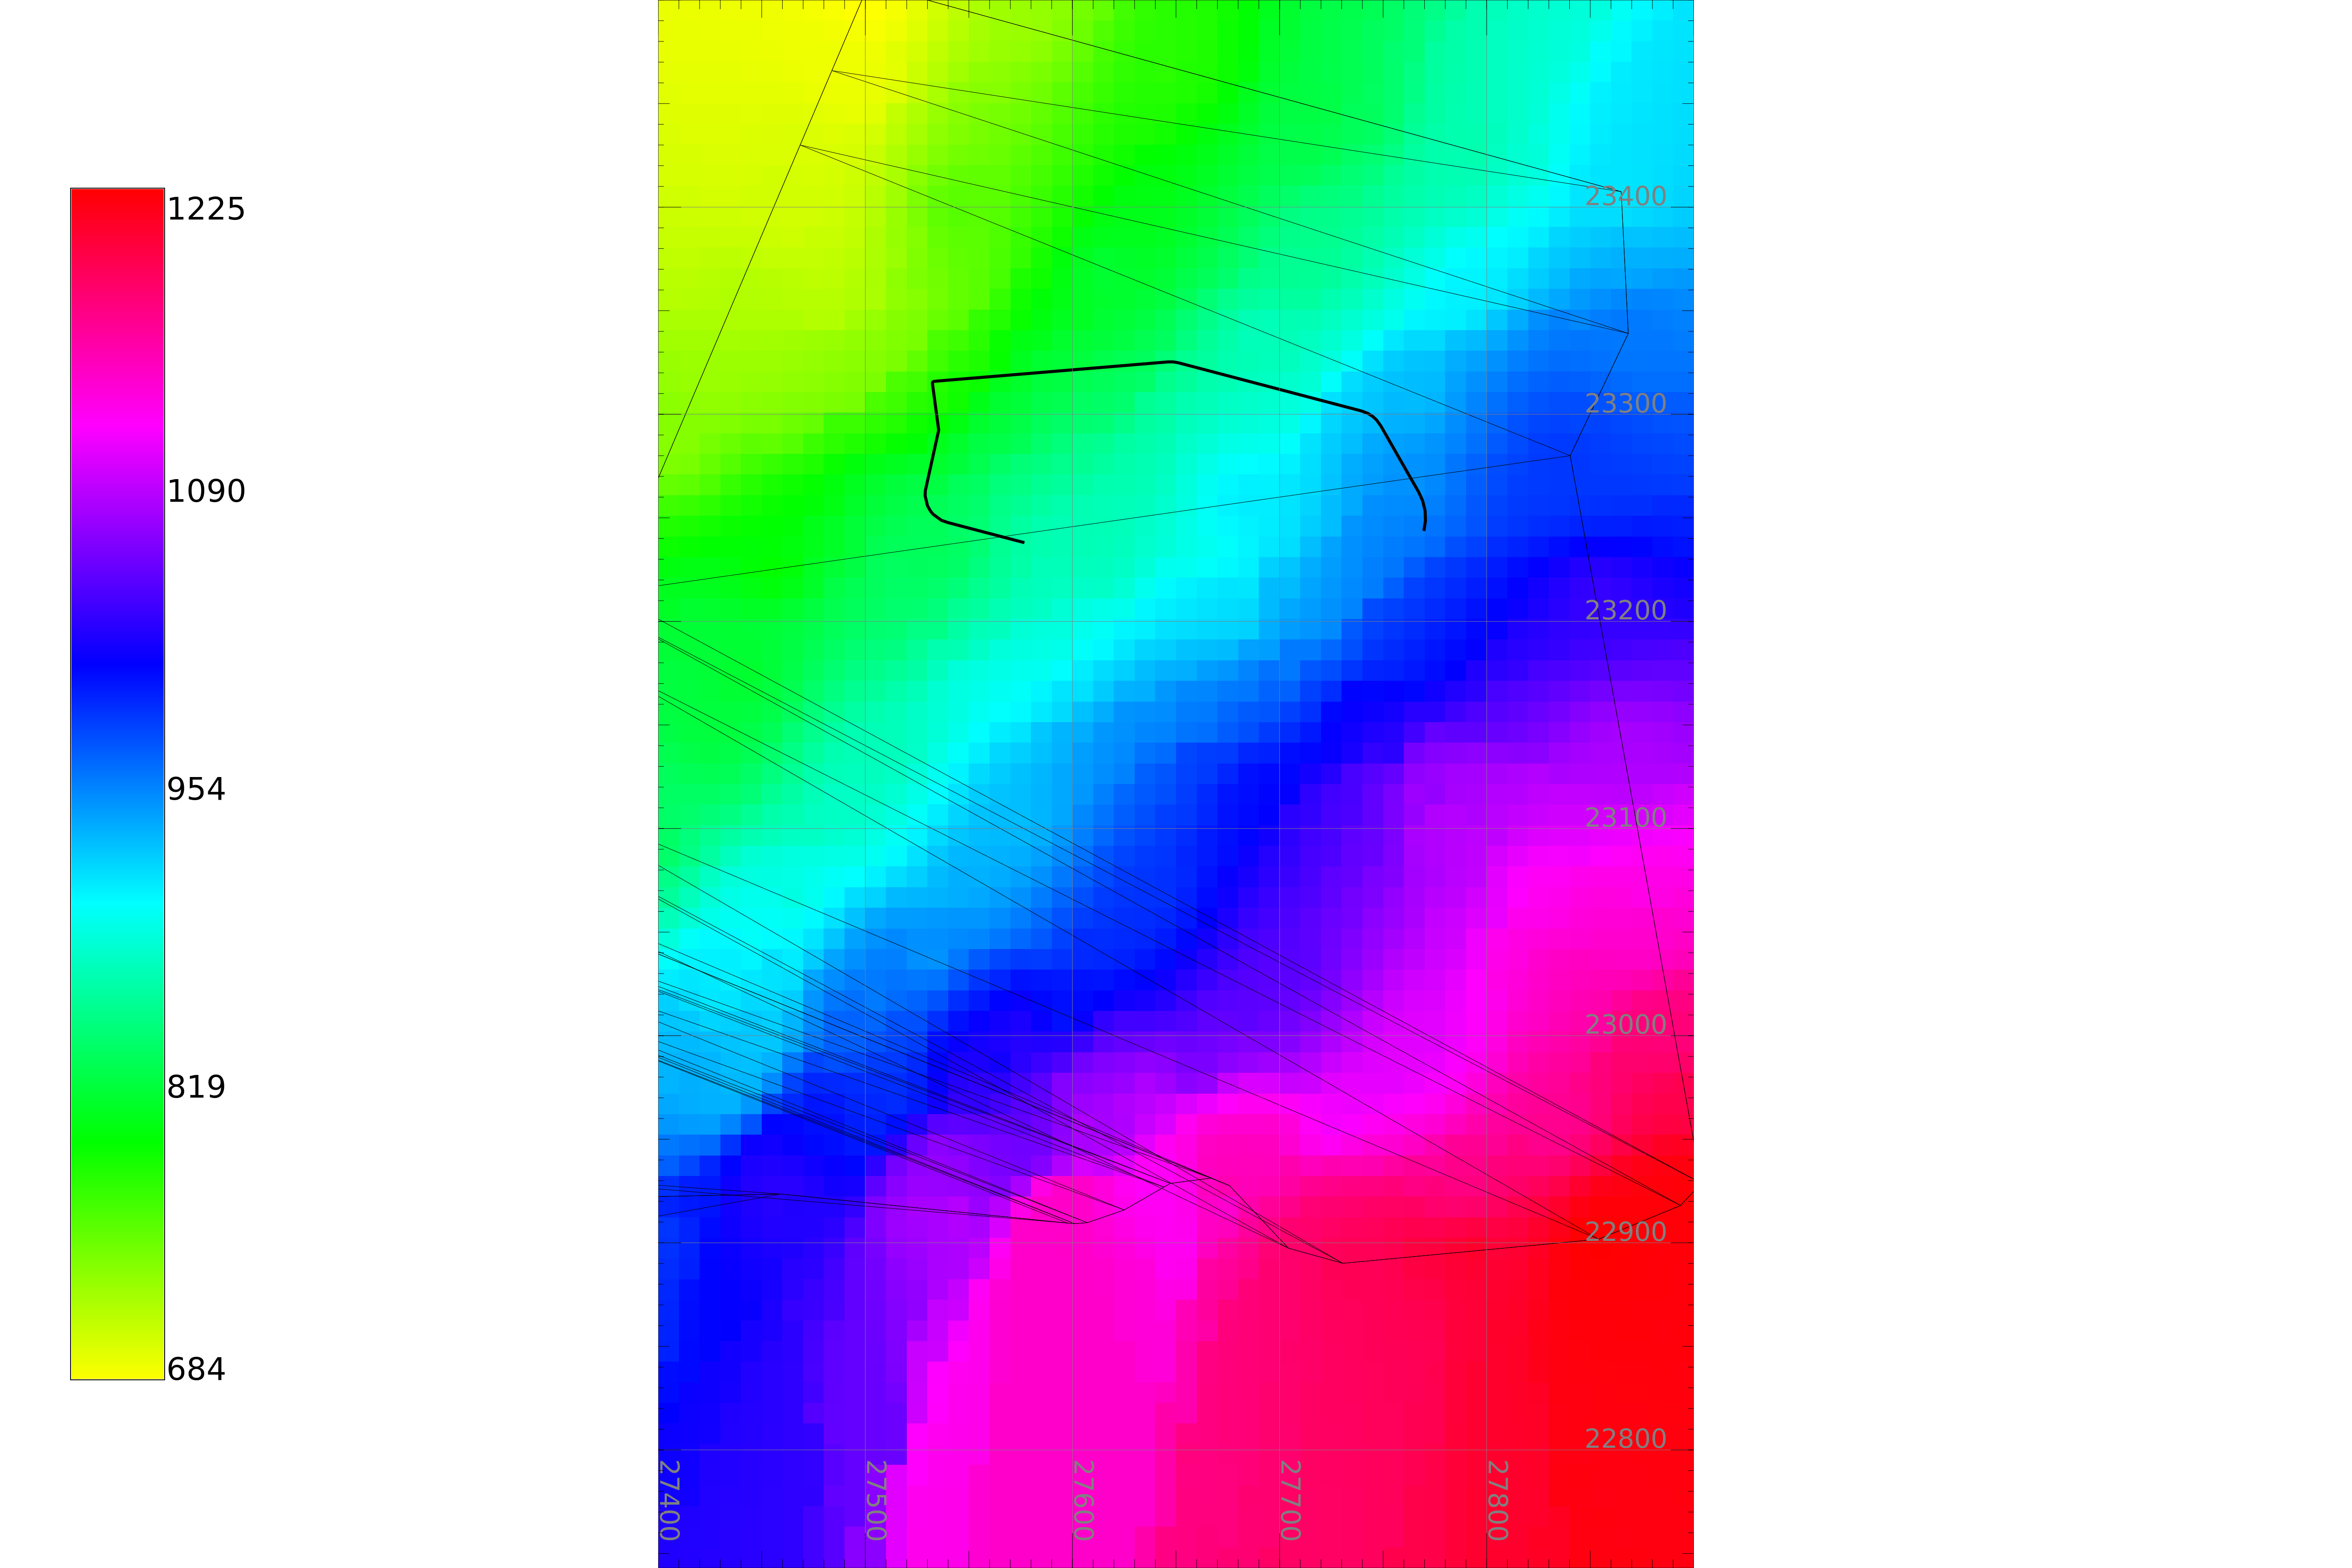

In [32]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)

#read_grass("d.rast", map=faults_rast_[0], bgcolor='white', flags='n')
read_grass("d.rast", map=faults_rast[0], bgcolor='white', flags='n')


read2_command("d.vect", map=faults_vect[0], color='black')

# display Drainage Gallery DG3 alignment
read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=7)

#show legend and grid, display result
read_grass("d.legend", raster=faults_rast_[0], fontsize='72')[1]
read_grass("d.grid", size=100, fontsize=60)[0]
Image(filename="map.png")

In [33]:
faults_rast_

['fault_rast__3']

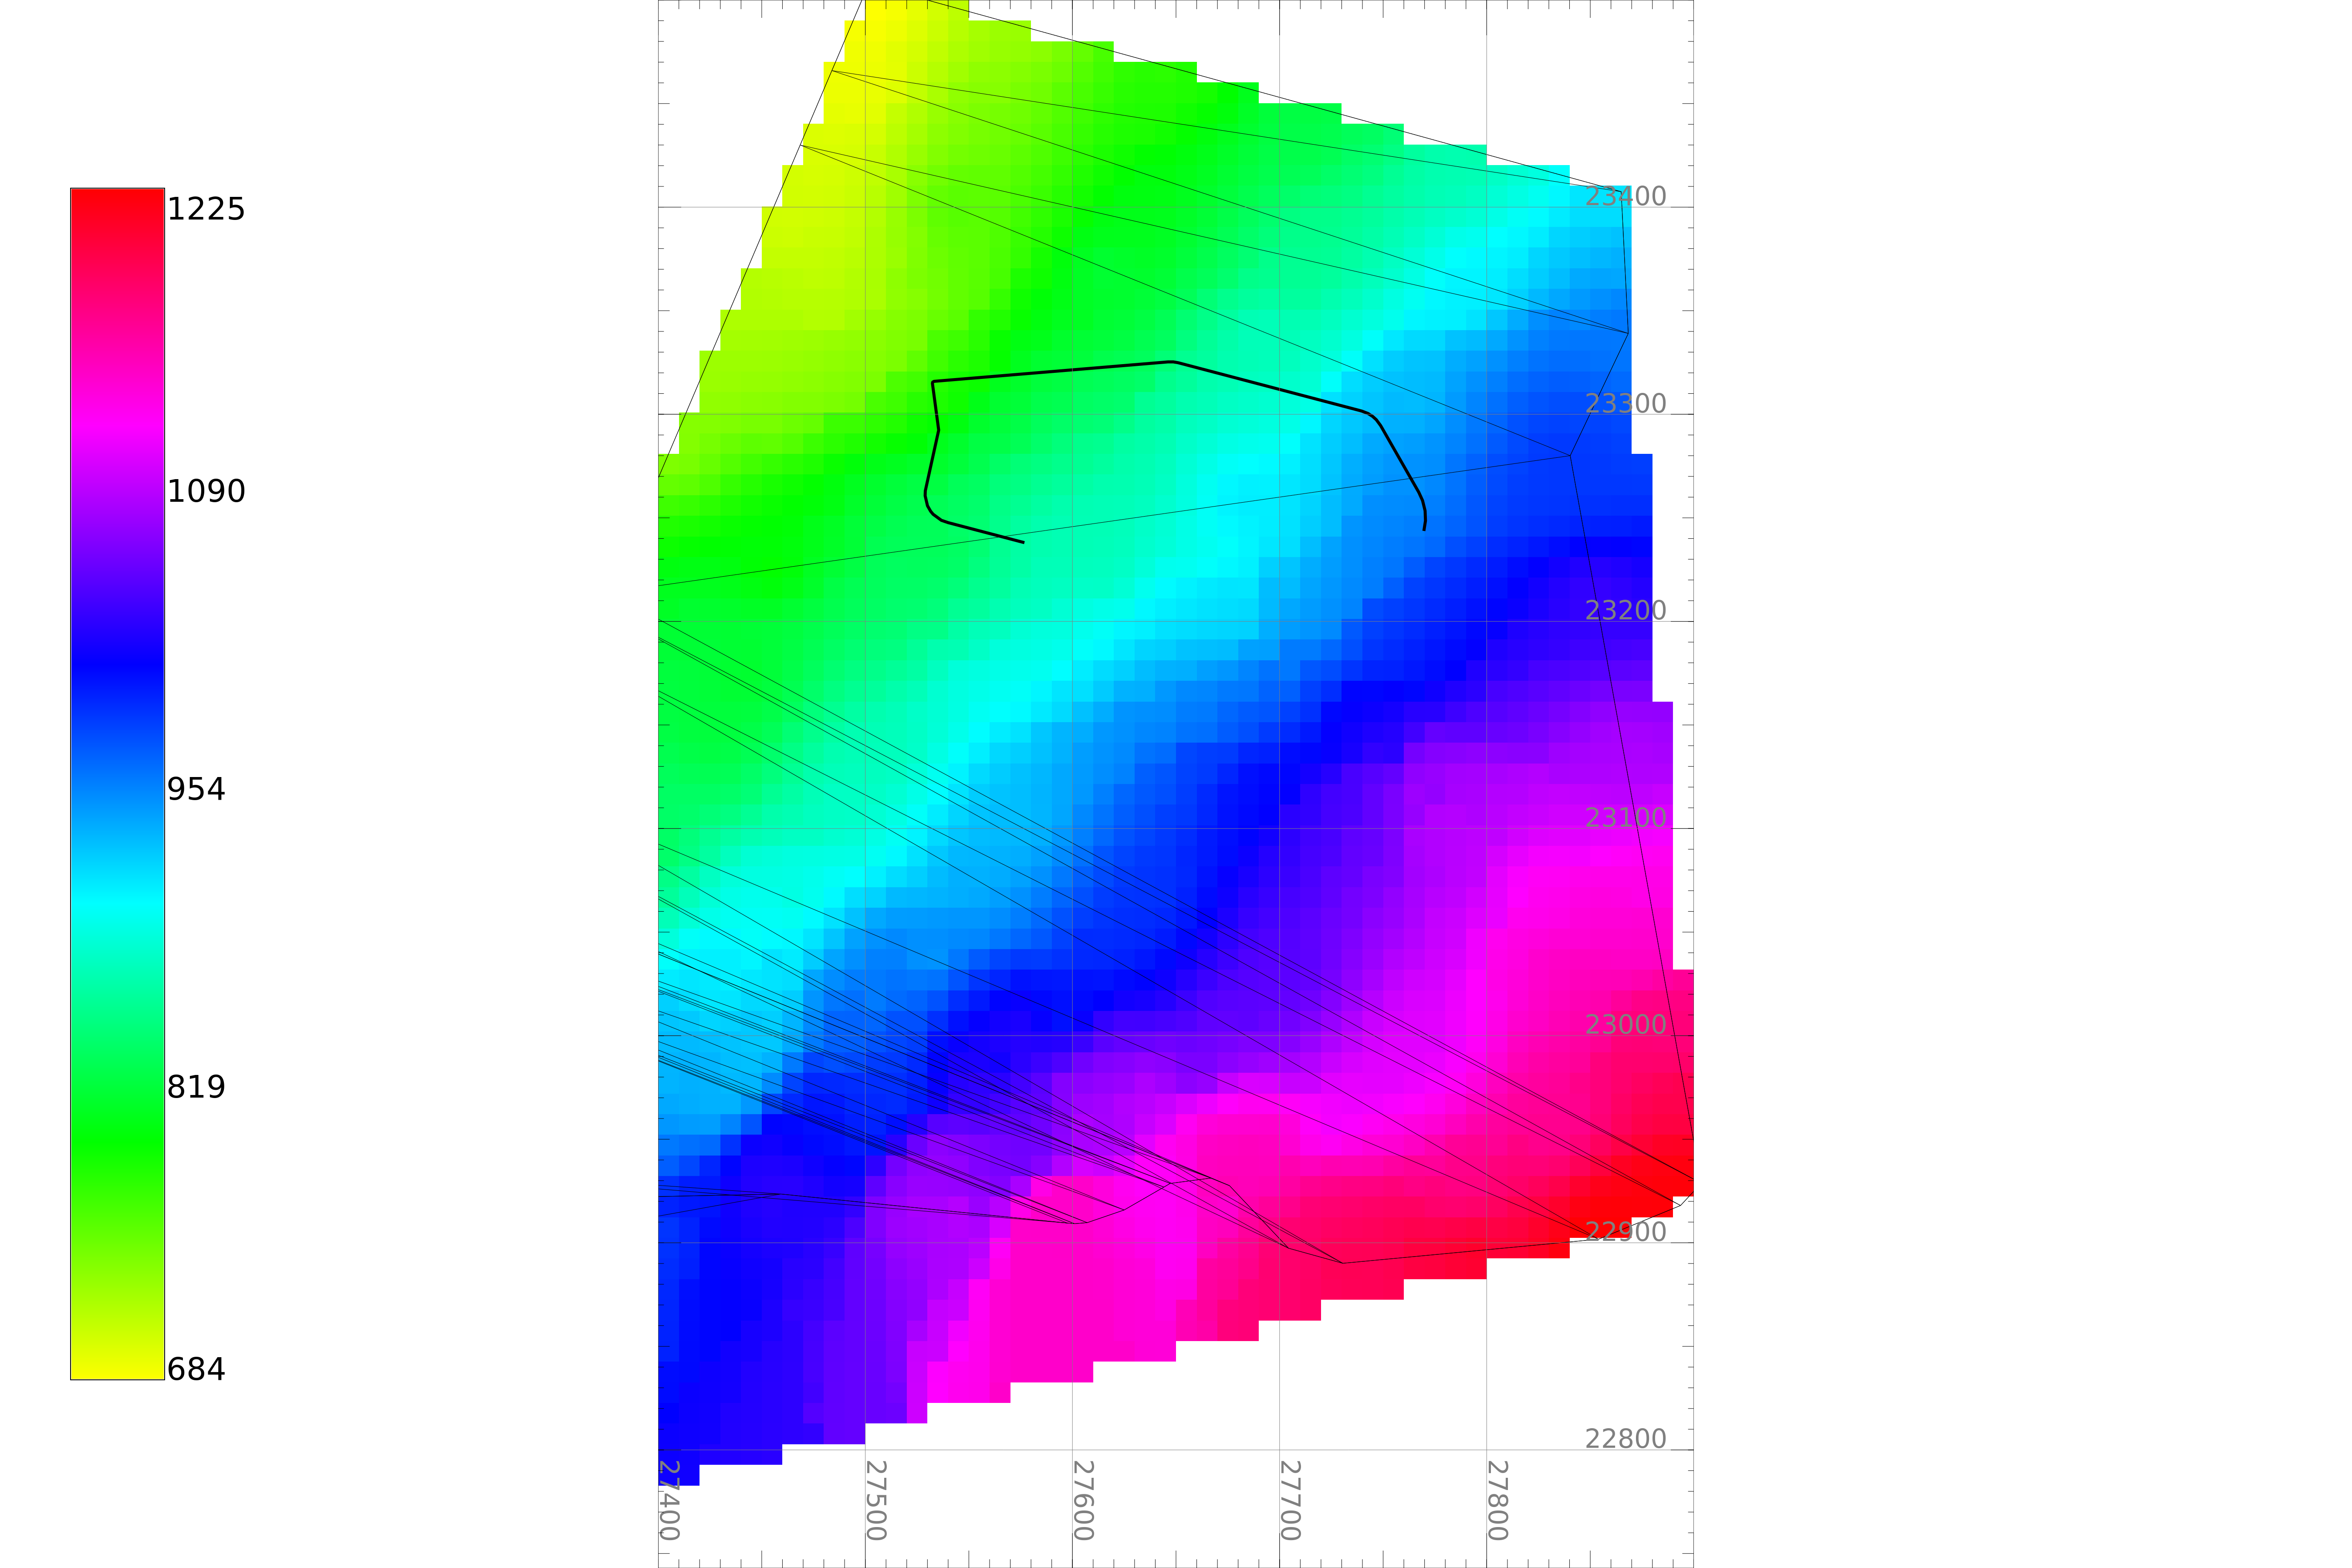

In [34]:
# display topography raster DEM
!rm map.png

read_grass("d.rast", map=faults_rast_[0], bgcolor='white', flags='n')
#read_grass("d.rast", map=faults_rast[0], bgcolor='white', flags='n')


read2_command("d.vect", map=faults_vect[0], color='black')

# display Drainage Gallery DG3 alignment
read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=7)

#show legend and grid, display result
read_grass("d.legend", raster=faults_rast_[0], fontsize='72')[1]
read_grass("d.grid", size=100, fontsize=60)[0]
Image(filename="map.png")

In [35]:
# # display topography raster DEM
# !rm map.png

# read_grass("d.rast", map=faults_rast_[1], bgcolor='white', flags='n')

# read2_command("d.vect", map=faults_vect[1], color='black')

# # display Drainage Gallery DG3 alignment
# read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=7)

# #show legend and grid, display result
# read_grass("d.legend", raster=faults_rast[1], fontsize='72')[1]
# read_grass("d.grid", size=100, fontsize=60)[0]
# Image(filename="map.png")

In [36]:
# # display topography raster DEM
# !rm map.png

# read_grass("d.rast", map=faults_rast_[2], bgcolor='white', flags='n')

# read2_command("d.vect", map=faults_vect[2], color='black')

# # display Drainage Gallery DG3 alignment
# read2_command('d.vect', map='alignment_dg3_cleaned', color='black', width=7)

# #show legend and grid, display result
# read_grass("d.legend", raster=faults_rast[2], fontsize='72')[1]
# read_grass("d.grid", size=100, fontsize=60)[0]
# Image(filename="map.png")

In [37]:
# for checking with qgis - write resa mp;ed raster data to tif file
!r.out.gdal input=fault_rast_3 output=fault_rast_3.tif  #output file seems ok & mask is applied
#!r.out.gdal input=faults_rast output=faults_rast.png format=PNG  #error with libpng

Checking GDAL data type and nodata value...
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
Using GDAL data type <Float64>
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
r.out.gdal complete. File <fault_rast_3.tif> created.


In [38]:
!file fault_rast_3.tif

fault_rast_3.tif: TIFF image data, little-endian, direntries=17, height=76, bps=64, compression=none, PhotometricIntepretation=BlackIsZero, width=50


## determine raster below an x,y,z point (initial developent and testing only)

In [39]:
def parse_grass_out(out):
# converts grass output string from grass "r.what" to a numpy array of float values
    out2 = out.replace('\n','')
    print(out2)
    out3 = np.array(out2.split(','))
    print(out3)
    out4 = np.delete(out3,2)
    print(out4)    
    # return float values of string values
    return(out4.astype(np.float))
    

In [40]:
# coordinates of a test point

#xx = 27600
#yy= 23400
#zz = 1025

# xx = 27700
# yy= 23340
# zz = 1025

# near start (eastern end) of alignment DG3
xx = 27750
yy= 23250
zz = 1025

In [41]:
#lithologies

In [42]:
def what_lithology(x, y, z):
    '''Find lithology at a point
    
    Surfaces and litholgies must be previously defined and ordered from top to bottom.
    Surfaces are the contact surface between two geological layers
    Litholgies correspond to downside layer litholgy of a surface.

    Args:
        x,y,z - coordinates of a point
        
    Requires:
        lithologies - list of lithologies
        surfaces_rast_ - list of grass masked surface rasters

    Returns:
        lithology of nearest contact surface below point x,y,z
        'NaN' if no contact surface is below point x,y,z

    '''
    
    coords=(x,y)
    z_out = []
    lithology_z = 'NaN'
    
    # get z of each layer at point x,y 
    # parse grass output to return a numpy array of float values
    for surface in surfaces_rast_:
        z_out.append(parse_grass_out(
                       read_grass("r.what", map=surface, separator=',', null_value='NaN', 
                                  coordinates=coords)[0]))
                       # consider calling multiple maps and/or multiple points (see r.what doc)
                       # to speed up execution                                                      #ToDo JK

    ## sort layers by z (bottom to top sorting)
    #z_out_ = np.sort(z_out, axis=0)  #this works, but only because x an y in each record or the same
    #                                 #look for a more universal sorting method                      #ToDo JK
    z_out_ = np.array(z_out)
    print(z_out_, '\n')

    # locate lithology for a point x,y,z considering all geological layers  
    for surface, lithology in zip(z_out_, lithologies):
        # loop through layers from bottom to top
        # requires 'layer' and 'layer_lithology' both sorted from bottom to top
        print('\n', surface)
        print(surface[2])
        print(lithology)
        if np.isnan(surface[2]):
            print("nan !!!")
            # layer does not extend to point
            # skip to next layer
            continue
        elif surface[2] > zz:
            # layer is below elevation z of point and is a candidate layer for point
            lithology_z = lithology
        else:
            # surface is at or below elevation z of point and is not a candidate surface for point
            # therefore point lies in previously set 'lithology_z = layer_lithology'
            # break out of 'for loop'
            print("break !!!")
            break
        
    return(lithology_z) 

In [43]:
# lithology_z = what_lithology(xx, yy, zz)
# print('\n', 'litholgy: ', lithology_z)    

In [44]:
# # testing excution speed  
# #   74 sec for 1000 points and for 2 layers
# #   99% for grass r.what
# zzz = np.linspace(1080, 1200, num=1000)
# lithology_z = []
# for zz in zzz:
#     lithology_z.append(what_lithology(xx, yy, zz))

# lithology_z    